In [ ]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque
from torch.utils.tensorboard import SummaryWriter
from torch.optim import Adam
import matplotlib.pyplot as plt
import os
from abc import ABC, abstractmethod

np.bool8 = np.bool_  # Fix for newer NumPy versions

# ----------------------------
# Utils
# ----------------------------

def compute_gx(state):
    x, _, theta, _ = state
    m1 = 2.4 - abs(x)
    m2 = np.deg2rad(12) - abs(theta)
    return min(m1, m2 / 5)

def update_params(optim, loss, retain_graph=False):
    optim.zero_grad()
    loss.backward(retain_graph=retain_graph)
    optim.step()

def disable_gradients(network):
    for param in network.parameters():
        param.requires_grad = False

def soft_update(target, source, tau):
    for t, s in zip(target.parameters(), source.parameters()):
        t.data.copy_(t.data * (1.0 - tau) + s.data * tau)

# ----------------------------
# Networks
# ----------------------------

def initialize_weights_xavier(m, gain=1.0):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight, gain=gain)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

class PolicyNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, action_dim)
        )

    def forward(self, state):
        logits = self.net(state)
        return F.softmax(logits, dim=-1)

class StateActionFunction(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_units=[256, 256]):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, hidden_units[0]), nn.ReLU(),
            nn.Linear(hidden_units[0], hidden_units[1]), nn.ReLU(),
            nn.Linear(hidden_units[1], 1)
        )

    def forward(self, x):
        return self.net(x)

class TwinnedStateActionFunction(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_units=[256, 256]):
        super().__init__()
        self.net1 = StateActionFunction(state_dim, action_dim, hidden_units)
        self.net2 = StateActionFunction(state_dim, action_dim, hidden_units)

    def forward(self, states, actions):
        x = torch.cat([states, actions], dim=1)
        return self.net1(x), self.net2(x)

# ----------------------------
# Replay Buffers
# ----------------------------

class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)

    def append(self, s, a, r, s2, done):
        self.buffer.append((s, a, r, s2, done))

    def sample(self, batch_size, device):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        s, a, r, s2, d = zip(*[self.buffer[i] for i in indices])
        return (
            torch.tensor(s, dtype=torch.float32, device=device),
            torch.tensor(a, dtype=torch.int64, device=device).unsqueeze(1),
            torch.tensor(r, dtype=torch.float32, device=device).unsqueeze(1),
            torch.tensor(s2, dtype=torch.float32, device=device),
            torch.tensor(d, dtype=torch.float32, device=device).unsqueeze(1)
        )

    def __len__(self):
        return len(self.buffer)

class ReplayBufferHJB(ReplayBuffer):
    def append(self, s, a, gx, s2, done):
        self.buffer.append((s, a, gx, s2, done))

    def sample(self, batch_size, device):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        s, a, gx, s2, d = zip(*[self.buffer[i] for i in indices])
        return (
            torch.tensor(s, dtype=torch.float32, device=device),
            torch.tensor(a, dtype=torch.int64, device=device).unsqueeze(1),
            torch.tensor(gx, dtype=torch.float32, device=device).unsqueeze(1),
            torch.tensor(s2, dtype=torch.float32, device=device),
            torch.tensor(d, dtype=torch.float32, device=device).unsqueeze(1)
        )


In [ ]:
class Algorithm(ABC):
    @abstractmethod
    def __init__(self, state_dim, action_dim, device, gamma=0.99, nstep=1,
                 log_interval=10, seed=0):
        torch.manual_seed(seed)
        np.random.seed(seed)
        self._learning_steps = 0
        self._state_dim = state_dim
        self._action_dim = action_dim
        self._device = device
        self._gamma = gamma
        self._nstep = nstep
        self._discount = gamma ** nstep
        self._log_interval = log_interval

    @abstractmethod
    def explore(self, state): pass

    @abstractmethod
    def exploit(self, state): pass

    @abstractmethod
    def update_target_networks(self): pass

    @abstractmethod
    def update_online_networks(self, batch, writer): pass

class SAC(Algorithm):
    def __init__(self, state_dim, action_dim, device, gamma=0.99, nstep=1,
                 policy_lr=0.0003, q_lr=0.0003, entropy_lr=0.0003,
                 policy_hidden_units=[256, 256], q_hidden_units=[256, 256],
                 target_update_coef=0.005, log_interval=10, seed=0):
        super().__init__(state_dim, action_dim, device, gamma, nstep,
                         log_interval, seed)

        self._policy_net = PolicyNet(state_dim, action_dim).to(device)
        self._online_q_net = TwinnedStateActionFunction(state_dim, action_dim, q_hidden_units).to(device)
        self._target_q_net = TwinnedStateActionFunction(state_dim, action_dim, q_hidden_units).to(device)
        self._target_q_net.load_state_dict(self._online_q_net.state_dict())
        disable_gradients(self._target_q_net)

        self._policy_optim = Adam(self._policy_net.parameters(), lr=policy_lr)
        self._q_optim = Adam(self._online_q_net.parameters(), lr=q_lr)
        self._log_alpha = torch.zeros(1, device=device, requires_grad=True)
        self._alpha = self._log_alpha.detach().exp()
        self._alpha_optim = Adam([self._log_alpha], lr=entropy_lr)
        self._target_entropy = -float(action_dim)
        self._target_update_coef = target_update_coef
        self.update_entropy = True

    def explore(self, state):
        state = torch.tensor(state[None, ...], dtype=torch.float32).to(self._device)
        with torch.no_grad():
            probs = self._policy_net(state)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()
        return action.item(), None

    def exploit(self, state):
        state = torch.tensor(state[None, ...], dtype=torch.float32).to(self._device)
        with torch.no_grad():
            probs = self._policy_net(state)
            action = torch.argmax(probs, dim=1)
        return action.item(), None

    def get_q_value(self, state_tensor, one_hot_action_tensor):
        q1, q2 = self._online_q_net(state_tensor, one_hot_action_tensor)
        return torch.min(q1, q2).item()

    def update_target_networks(self):
        soft_update(self._target_q_net, self._online_q_net, self._target_update_coef)

    def update_online_networks(self, batch, writer):
        self._learning_steps += 1
        stats = self.update_policy_and_entropy(batch, writer)
        self.update_q_functions(batch, writer)
        return stats

    def update_policy_and_entropy(self, batch, writer):
        states, actions, rewards, next_states, dones = batch
        probs = self._policy_net(states)
        dist = torch.distributions.Categorical(probs)
        sampled_actions = dist.sample()
        log_probs = dist.log_prob(sampled_actions).unsqueeze(1)
        one_hot = F.one_hot(sampled_actions, num_classes=self._action_dim).float()
        qs1, qs2 = self._online_q_net(states, one_hot)
        qs = torch.min(qs1, qs2)
        policy_loss = torch.mean(-qs - self._alpha * log_probs)
        update_params(self._policy_optim, policy_loss)

        if self.update_entropy:
            entropy_loss = -torch.mean(self._log_alpha * (self._target_entropy - log_probs.detach()))
            update_params(self._alpha_optim, entropy_loss)
        self._alpha = self._log_alpha.detach().exp()

        return {"policy_loss": policy_loss.item(), "entropy_loss": entropy_loss.item()}

    def update_q_functions(self, batch, writer, imp_ws1=None, imp_ws2=None):
        states, actions, rewards, next_states, dones = batch
        one_hot = F.one_hot(actions.squeeze(1), num_classes=self._action_dim).float()
        curr_qs1, curr_qs2 = self._online_q_net(states, one_hot)

        with torch.no_grad():
            probs = self._policy_net(next_states)
            dist = torch.distributions.Categorical(probs)
            next_actions = dist.sample()
            log_probs = dist.log_prob(next_actions).unsqueeze(1)
            next_one_hot = F.one_hot(next_actions, num_classes=self._action_dim).float()
            next_qs1, next_qs2 = self._target_q_net(next_states, next_one_hot)
            next_qs = torch.min(next_qs1, next_qs2) + self._alpha * log_probs
            target_qs = rewards + (1.0 - dones) * self._discount * next_qs

        q_loss = F.mse_loss(curr_qs1, target_qs) + F.mse_loss(curr_qs2, target_qs)
        update_params(self._q_optim, q_loss)

class SACHJB(SAC):
    def update_policy_and_entropy(self, batch, writer):
        states, actions, gxs, next_states, dones = batch
        return super().update_policy_and_entropy((states, actions, gxs, next_states, dones), writer)

    def update_q_functions(self, batch, writer, imp_ws1=None, imp_ws2=None):
        states, actions, gxs, next_states, dones = batch
        one_hot = F.one_hot(actions.squeeze(1), num_classes=self._action_dim).float()
        curr_qs1, curr_qs2 = self._online_q_net(states, one_hot)

        with torch.no_grad():
            probs = self._policy_net(next_states)
            dist = torch.distributions.Categorical(probs)
            next_actions = dist.sample()
            log_probs = dist.log_prob(next_actions).unsqueeze(1)
            next_one_hot = F.one_hot(next_actions, num_classes=self._action_dim).float()
            next_qs1, next_qs2 = self._target_q_net(next_states, next_one_hot)
            next_qs = torch.min(next_qs1, next_qs2)
            next_qs = torch.min(gxs, next_qs) + self._alpha * log_probs
            ra = (1 - self._discount) * gxs + self._discount * next_qs
            target_qs = dones * gxs + (1 - dones) * ra

        q_loss = F.mse_loss(curr_qs1, target_qs) + F.mse_loss(curr_qs2, target_qs)
        update_params(self._q_optim, q_loss)


In [ ]:
# =========================
# FINAL: BASELINE AGENT
# =========================
def run_cartpole_baseline(num_episodes=1000):
    import gym
    import torch
    import numpy as np
    from torch.utils.tensorboard import SummaryWriter

    env = gym.make("CartPole-v1")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    sac_agent = SAC(state_dim, action_dim, device=device)
    buffer = ReplayBuffer(capacity=200000)
    writer = SummaryWriter()

    rewards = []
    safe_steps_baseline = []
    baseline_violations = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        safe_step_counter = 0
        unsafe_flag = False
        gx_violations = 0

        while not done:
            action = env.action_space.sample() if len(buffer) < 256 else sac_agent.explore(state)[0]
            next_state, reward, done, _ = env.step(action)
            gx = compute_gx(state)

            if gx < 0:
                gx_violations += 1

            if not unsafe_flag and gx >= 0:
                safe_step_counter += 1
            elif gx < 0 and not unsafe_flag:
                unsafe_flag = True

            buffer.append(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if len(buffer) >= 256:
                batch = buffer.sample(256, device)
                sac_agent.update_q_functions(batch, writer)
                sac_agent.update_policy_and_entropy(batch, writer)

        rewards.append(total_reward)
        safe_steps_baseline.append(safe_step_counter)
        baseline_violations.append(gx_violations)

        if episode % 50 == 0:
            print(f"Baseline Episode {episode}: Reward = {total_reward}, Safe Steps = {safe_step_counter}, gx<0 Violations = {gx_violations}")

    return rewards, safe_steps_baseline, baseline_violations

In [ ]:
# =========================
# FINAL: SAFETY AGENT
# =========================
def run_cartpole_safety(num_episodes=1000, scale_gx=10.0, q_updates_per_step=5):
    import gym
    import torch
    import numpy as np
    import torch.nn.functional as F
    from torch.utils.tensorboard import SummaryWriter

    env = gym.make("CartPole-v1")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    sac_agent = SACHJB(state_dim, action_dim, device=device)
    sac_buffer = ReplayBufferHJB(capacity=200000)
    writer = SummaryWriter()

    rewards_safe = []
    steps_safe = []
    lrsf_random_counts = []
    lrsf_shield_counts = []

    for episode in range(num_episodes):
        warmup_steps = np.random.randint(5)
        state = env.reset()
        done = False
        for _ in range(warmup_steps):
            a = env.action_space.sample()
            ns, _, done, _ = env.step(a)
            gx = scale_gx * compute_gx(state)
            sac_buffer.append(state, a, gx, ns, done)
            state = ns if not done else env.reset()

        total_reward = 0
        steps = 0
        done = False
        while not done:
            with torch.no_grad():
                st = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                probs = sac_agent._policy_net(st)
                dist = torch.distributions.Categorical(probs)
                action = dist.sample().item()

            next_state, reward, done, _ = env.step(action)
            gx = scale_gx * compute_gx(state)
            sac_buffer.append(state, action, gx, next_state, done)
            state = next_state
            total_reward += reward
            steps += 1
            if gx < 0:
                break

            if len(sac_buffer) >= 256:
                for _ in range(q_updates_per_step):
                    batch = sac_buffer.sample(256, device)
                    sac_agent.update_q_functions(batch, writer)
                    sac_agent.update_policy_and_entropy(batch, writer)

        rewards_safe.append(total_reward)
        steps_safe.append(steps)

        if episode % 50 == 0:
            test_env = gym.make("CartPole-v1")
            s = test_env.reset()
            done = False
            shield_count, random_count = 0, 0
            action_dim_eval = test_env.action_space.n

            while not done:
                shield_action, _ = sac_agent.exploit(s)
                st = torch.tensor(s, dtype=torch.float32).unsqueeze(0).to(device)
                a_onehot = F.one_hot(torch.tensor([shield_action]), num_classes=action_dim_eval).float().to(device)
                q_val = sac_agent.get_q_value(st, a_onehot)
                a = test_env.action_space.sample() if q_val > 0 else shield_action
                if q_val > 0:
                    random_count += 1
                else:
                    shield_count += 1
                s, _, done, _ = test_env.step(a)
                if compute_gx(s) < 0:
                    break

            lrsf_random_counts.append(random_count)
            lrsf_shield_counts.append(shield_count)
            print(f"[LRSF Eval] Episode {episode}: Steps survived = {random_count + shield_count}, Q > 0: {random_count}, Q <= 0: {shield_count}")

    return rewards_safe, steps_safe, lrsf_random_counts, lrsf_shield_counts

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Baseline Episode 0: Reward = 34.0, Safe Steps = 34, gx<0 Violations = 0


<ipython-input-1-6c0feec50203>:98: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  torch.tensor(s, dtype=torch.float32, device=device),


Baseline Episode 50: Reward = 16.0, Safe Steps = 16, gx<0 Violations = 0
Baseline Episode 100: Reward = 9.0, Safe Steps = 9, gx<0 Violations = 0
Baseline Episode 150: Reward = 10.0, Safe Steps = 10, gx<0 Violations = 0
Baseline Episode 200: Reward = 14.0, Safe Steps = 14, gx<0 Violations = 0
Baseline Episode 250: Reward = 16.0, Safe Steps = 16, gx<0 Violations = 0
Baseline Episode 300: Reward = 16.0, Safe Steps = 16, gx<0 Violations = 0
Baseline Episode 350: Reward = 11.0, Safe Steps = 11, gx<0 Violations = 0
Baseline Episode 400: Reward = 9.0, Safe Steps = 9, gx<0 Violations = 0
Baseline Episode 450: Reward = 9.0, Safe Steps = 9, gx<0 Violations = 0
Baseline Episode 500: Reward = 9.0, Safe Steps = 9, gx<0 Violations = 0
Baseline Episode 550: Reward = 9.0, Safe Steps = 9, gx<0 Violations = 0
Baseline Episode 600: Reward = 12.0, Safe Steps = 12, gx<0 Violations = 0
Baseline Episode 650: Reward = 10.0, Safe Steps = 10, gx<0 Violations = 0
Baseline Episode 700: Reward = 8.0, Safe Steps = 

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


[LRSF Eval] Episode 0: Steps survived = 13, Q > 0: 0, Q <= 0: 13
[LRSF Eval] Episode 50: Steps survived = 15, Q > 0: 1, Q <= 0: 14
[LRSF Eval] Episode 100: Steps survived = 10, Q > 0: 0, Q <= 0: 10
[LRSF Eval] Episode 150: Steps survived = 10, Q > 0: 0, Q <= 0: 10
[LRSF Eval] Episode 200: Steps survived = 9, Q > 0: 1, Q <= 0: 8
[LRSF Eval] Episode 250: Steps survived = 16, Q > 0: 1, Q <= 0: 15
[LRSF Eval] Episode 300: Steps survived = 9, Q > 0: 1, Q <= 0: 8
[LRSF Eval] Episode 350: Steps survived = 10, Q > 0: 1, Q <= 0: 9
[LRSF Eval] Episode 400: Steps survived = 9, Q > 0: 1, Q <= 0: 8
[LRSF Eval] Episode 450: Steps survived = 10, Q > 0: 1, Q <= 0: 9
[LRSF Eval] Episode 500: Steps survived = 9, Q > 0: 1, Q <= 0: 8
[LRSF Eval] Episode 550: Steps survived = 9, Q > 0: 1, Q <= 0: 8
[LRSF Eval] Episode 600: Steps survived = 8, Q > 0: 1, Q <= 0: 7
[LRSF Eval] Episode 650: Steps survived = 8, Q > 0: 1, Q <= 0: 7
[LRSF Eval] Episode 700: Steps survived = 9, Q > 0: 1, Q <= 0: 8
[LRSF Eval] Epis

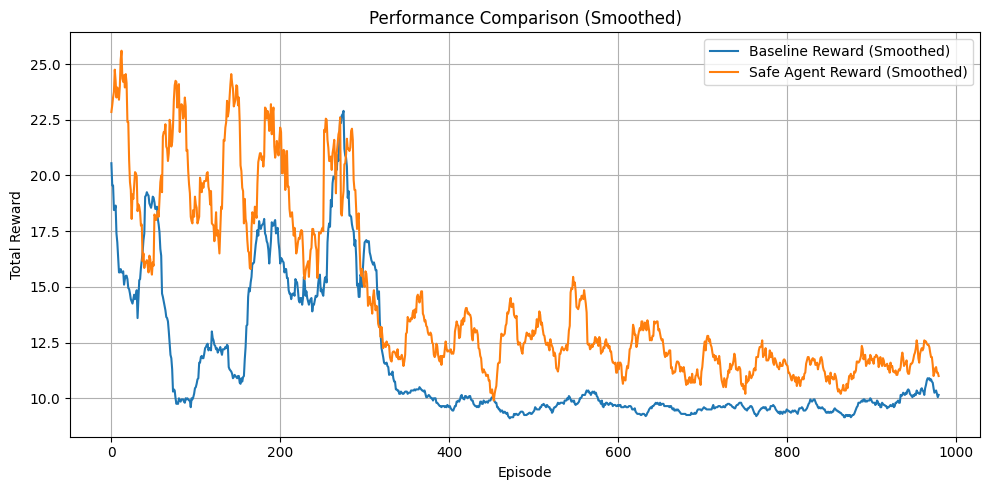

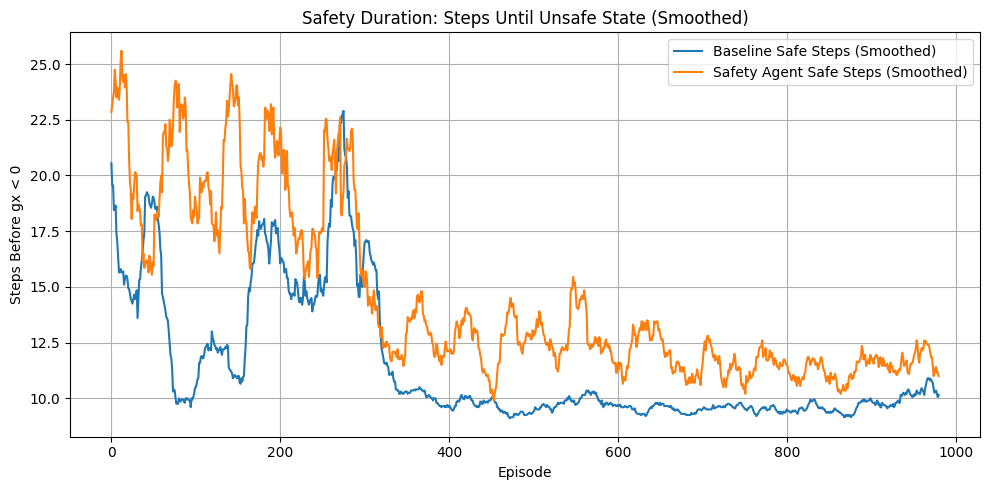

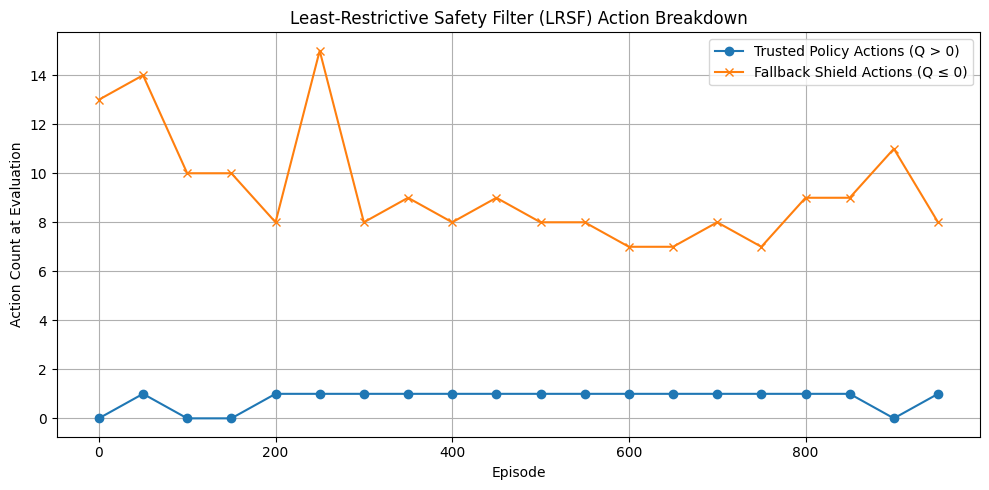

In [ ]:
# =========================
# FINAL: PLOTTING SECTION
# =========================
import matplotlib.pyplot as plt
import numpy as np

# Moving average smoothing
def moving_average(data, window_size=20):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

baseline_rewards, baseline_safe, _ = run_cartpole_baseline()
safe_rewards, safe_steps, lrsf_random, lrsf_shield = run_cartpole_safety()

# 1. Performance Comparison (Smoothed)
plt.figure(figsize=(10, 5))
plt.plot(
    range(len(moving_average(baseline_rewards))),
    moving_average(baseline_rewards),
    label="Baseline Reward (Smoothed)", linestyle='-'
)
plt.plot(
    range(len(moving_average(safe_rewards))),
    moving_average(safe_rewards),
    label="Safe Agent Reward (Smoothed)", linestyle='-'
)
plt.title("Performance Comparison (Smoothed)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Safety Duration (Smoothed Steps Until gx < 0)
plt.figure(figsize=(10, 5))
plt.plot(
    range(len(moving_average(baseline_safe))),
    moving_average(baseline_safe),
    label="Baseline Safe Steps (Smoothed)", linestyle='-'
)
plt.plot(
    range(len(moving_average(safe_steps))),
    moving_average(safe_steps),
    label="Safety Agent Safe Steps (Smoothed)", linestyle='-'
)
plt.title("Safety Duration: Steps Until Unsafe State (Smoothed)")
plt.xlabel("Episode")
plt.ylabel("Steps Before gx < 0")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Least-Restrictive Safety Filter (LRSF) Decision Breakdown
eval_points = [i for i in range(0, len(lrsf_random) * 50, 50)]
plt.figure(figsize=(10, 5))
plt.plot(eval_points, lrsf_random, label="Trusted Policy Actions (Q > 0)", marker='o')
plt.plot(eval_points, lrsf_shield, label="Fallback Shield Actions (Q ≤ 0)", marker='x')
plt.title("Least-Restrictive Safety Filter (LRSF) Action Breakdown")
plt.xlabel("Episode")
plt.ylabel("Action Count at Evaluation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
